In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
from datetime import datetime
import seaborn as sns
from typing import *
import scipy.stats as scistat
from scipy import special
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
import pymysql

In [ ]:
# MySQL connection details
host='localhost'
user='Tvan'
password='Tvan217desu~'
database='personal_finance'

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")  #<- Create engine for MySQL connection

query = "SELECT * FROM transactions"                                            #<- SQL query to fetch data from transactions table
df = pd.read_sql(query, con=engine)                                             #<- Read data into a DataFrame

df

,trans_no,date,details,amount,transaction,transaction_mode
0,1,2023-09-14,サラリー,17732.0,Income,Bank
1,2,2023-10-09,サラリー,12754.0,Income,Bank
2,3,2023-10-15,bank withdraw,26142.0,Withdraw,Bank
3,4,2023-10-15,stash deposit,26142.0,Deposit,Stash
4,5,2023-10-31,サラリー,12834.0,Income,Bank
...,...,...,...,...,...,...
745,746,2025-05-03,graduation celebration,5000.0,Expenses,Stash
746,747,2025-05-12,inom,440.0,Expenses,Stash
747,748,2025-05-22,Kape 2x,270.0,Expenses,Stash
748,750,2025-05-22,bioderm,50.0,Expenses,Stash


# **Data Cleaning**

In [15]:
# Appending `year`, `month`, and `day` data from the dataset
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['year'] = df['date'].dt.year

# Creating and Appending str date data
ymd = []        #<- `ymd` means year, month, and day (YY/MM/DD)
ym = []         #<- `ym` means year and month (YY/MM)

# Editing and Adding New Column Entry (Extracting Data)
detail_clean = []
for i, detail in df.iterrows():
    ym.append(f"{str(detail['year'])[2:]}/{detail['month']}")       #<- Appending `YY/MM`
    ymd.append(f"{str(detail['year'])[2:]}/{detail['month']}/{detail['day']}")  #<- Appending `YY/MM/DD`

    detail_lower = detail['details'].lower()
    if detail_lower == 'supa':
        detail_clean.append('Supa')
    elif detail_lower[:len('steam')] == 'steam':
        detail_clean.append('Steam')
    elif detail_lower[:len('aragmot')] == 'aragmot':
        detail_clean.append('Aragmot')
    elif detail_lower[:len('gcash cash-out')] == 'gcash cash-out':
        detail_clean.append('Gcash cash-out')
    elif detail_lower[-len('cash-in'):] == 'cash-in' or detail_lower[:len('gcash')] == 'gcash':
        detail_clean.append('Gcash cash-in')
    else:
        detail_clean.append(detail['details'])

df['detail_clean'] = detail_clean
df['y/m'] = ym
df['y/m/d'] = ymd

# Date Sorting No. (from earlier to current date)
date_arrangement = {}
for i, date in enumerate(df['y/m'].unique().tolist()):
    date_arrangement[date] = i

df['month sort no.'] = df['y/m'].map(date_arrangement)   #<- Appending Date Sorting No.

df

,trans_no,date,details,amount,transaction,transaction_mode,month,day,year,detail_clean,y/m,y/m/d,month sort no.
0,1,2023-09-14,サラリー,17732.0,Income,Bank,9,14,2023,サラリー,23/9,23/9/14,0
1,2,2023-10-09,サラリー,12754.0,Income,Bank,10,9,2023,サラリー,23/10,23/10/9,1
2,3,2023-10-15,bank withdraw,26142.0,Withdraw,Bank,10,15,2023,bank withdraw,23/10,23/10/15,1
3,4,2023-10-15,stash deposit,26142.0,Deposit,Stash,10,15,2023,stash deposit,23/10,23/10/15,1
4,5,2023-10-31,サラリー,12834.0,Income,Bank,10,31,2023,サラリー,23/10,23/10/31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,746,2025-05-03,graduation celebration,5000.0,Expenses,Stash,5,3,2025,graduation celebration,25/5,25/5/3,19
746,747,2025-05-12,inom,440.0,Expenses,Stash,5,12,2025,inom,25/5,25/5/12,19
747,748,2025-05-22,Kape 2x,270.0,Expenses,Stash,5,22,2025,Kape 2x,25/5,25/5/22,19
748,750,2025-05-22,bioderm,50.0,Expenses,Stash,5,22,2025,bioderm,25/5,25/5/22,19


In [16]:
# df['details'].value_counts()
df[(df['detail_clean'] == 'Gcash cash-in') & (df['transaction'] == 'Expenses')]

,trans_no,date,details,amount,transaction,transaction_mode,month,day,year,detail_clean,y/m,y/m/d,month sort no.
737,738,2025-04-28,Gcash cash-in,3000.0,Expenses,Stash,4,28,2025,Gcash cash-in,25/4,25/4/28,20


## **Class and Functional Programming**

In [ ]:
# Class Programming for Calc and Printing Mean and Standard Deviation
class StatsSummary:
    """Prints statistic summary (*mean*, *std*, *median*)
    
    ### **Parameter:**
    `data`
    - `DataFrame`, `dict`, or `array` type
    - the data to get its statistic summary
    -----------
    ### **Methods**
    - **`print_stats()`**
        - prints statistic summary
    - **`<class var>.data`**
        - get data
    - **`<class var>.mean`**
        - get mean of data
    - **`<class var>.median`**
        - get median of data
    - **`<class var>.std`**
        - get standard deviation of data
    - **`<class var>.stats`**
        - get dictionary of statistic summary"""

    def __init__(self, data) -> None:               #<- Instantiation
        self.data = data                            #<- Data
        self.stat_summary = data.describe()         #<- Count, mean, std, min, 25%, 50%, 75%, max
        self.mean = np.mean(data)                   #<- Mean
        self.median = np.median(data)               #<- Median
        self.std = np.std(data, ddof=1)             #<- Std (1 degree of freedom)
        self.stats: dict = {'Mean': self.mean, 'Standard Deviation': self.std, 'Median': self.median}
    

    def print_stats(self, mean: bool=True, std: bool=True, median: bool=False, round_digit:int = False) -> int|float:
        """Prints statistic summary.
        - Mean
        - Standard Deviation
        - Median"""
        
        stats = {'Mean': mean, 'Standard Deviation': std, 'Median': median}     #<- Dict for mean, std, and mean param checking

        for stat_key, stat in stats.items():                                    #<- Iter "stats" dict
            if stat:                                                            #<- Checks if mean, std, median param are true
                if type(round_digit) == int or round_digit == True :            #<- Checks "round_digit" type if int or it is True

                    if type(round_digit) != int:
                        print('WARNING!: `round_digit` must be an int not bool. Setting `round_digit` to 0.\n') #<- Warning message 
                        round_digit = 0                                                     #<- Setting to 0 since "True" can't mathematically operatable

                    print(f"{stat_key} = {np.round(self.stats[stat_key], round_digit)}")    #<- Prints rounded value
                else:
                    print(f"{stat_key} = {self.stats[stat_key]}")                           #<- Prints value as is


def plot_distribution(dataset: dict, fig_size: tuple = (10, 4)) -> None:
    """ ## **Function:**
    - Plotting distribution using `sns.histplot()` and `sns.boxplot()` in subplots.
    ---------
    ## **Parameters:**
    `dataset=`
    - `dict` type
    - The data you want to see the distribution.
    - Usage in code:
        - `data = [1, 2, 3, 4, 5]`
        - `plot_title = 'Data Distribution'`
        - `dict = {plot_title: data}`
            - Explanation:
                - `plot_title` -> title of your distribution plot.
                - `data` -> the data (could be `DataFrame` or `dict` type)"""

    row_count = len(dataset.keys())     #<- Checking how many data to plot (each row different data)
    iter_count = 0                   

    fig, ax = plt.subplots(row_count, 2, figsize=fig_size)      #<- Subplots with 2 columns

    if row_count < 2:                                           #<- If there's only 1 data
        axes = ax[0]
    else:                                                       #<- If there's more than 1 data
        axes = ax[iter_count, 0]

    for key, val in dataset.items():                                                #<- Iter dict "dataset"
        ax0 = sns.histplot(val, ax=axes, bins=30, kde=True)                         #<- Histogram
        ax0.set_title(key)                                                          #<- Title setting
        ax0.axvline(np.mean(val), color='red', linestyle='--', label='mean')        #<- Mean line
        ax0.axvline(np.median(val), color='gray', linestyle='--', label='median')   #<- Median line

        if row_count < 2:                                       #<- Incrementation for 1 data distribution check
            axes = ax[1]

        ax1 = sns.boxplot(x=val, ax=axes)                       #<- Box plot
        ax1.set_title(key)                                      #<- Title setting
        ax1.axvline(np.mean(val), color='red', linestyle='--', label='mean')
        
        iter_count += 1 
        
    plt.tight_layout()


def interp_pvalue(p_value, alpha:float = 0.05) -> None:
    """Checks if to **reject** or **fail to reject** null hypothesis."""

    if alpha < p_value:
        print(f"Fail to Reject Null Hypothesis. alpha < p-value is {alpha < p_value}")
    else:
        print(f"Reject Null Hypothesis. alpha < p-value is {alpha < p_value}")

## `transactions`
Visualizing transaction data

In [18]:
# Grouping by `transaction` and Summing up the Amount
transactions = df.groupby('transaction')['amount'].sum()
transactions

transaction
Deposit     312594.0
Expenses    323222.9
Income      619267.0
Withdraw    430040.0
Name: amount, dtype: float64

Text(0.5, 1.0, 'Transaction Status')

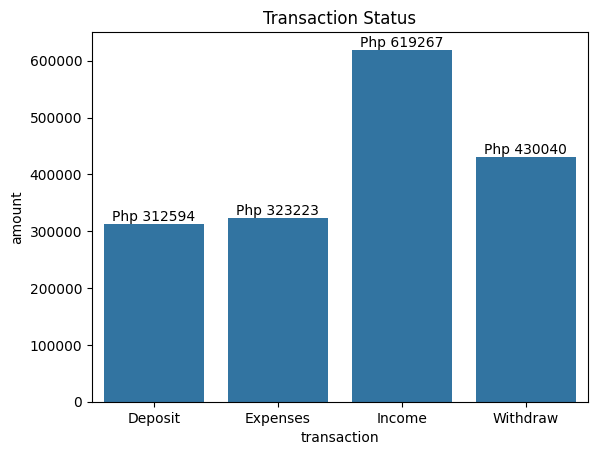

In [19]:
# Bar Plotting the Data
trans = sns.barplot(data=transactions)  #<- Bar plot
for bar in trans.patches:               #<- Data labels
    height = bar.get_height()

    if height > 0:
        trans.text(bar.get_x() + bar.get_width()/2, height, f'Php {height:.0f}', va='bottom', ha='center')
plt.title('Transaction Status')

transactions

In [20]:
percnt_diff = (transactions['Income'] - transactions['Expenses']) / transactions['Income']
print(f"Percent Difference of Expenses to Income = {percnt_diff * 100: .2f}%")

Percent Difference of Expenses to Income =  47.81%


### **Descriptive Interpretation**
- There are 48.29% percent difference between Expenses and Income.
- Meaning: There are 48.29% less total expenses, so far, if compared to total income.
    - Could be alarming if there are over 60%.
    - Could mean that we expending more than we earn.

## **`Expenses` transactions**
### Monthly Expenses

In [21]:
# Extracting `Expenses` and Make DF
df_expenses = df.loc[df['transaction'] == 'Expenses']

# Group by str `y/m` and Sum their Amount
grpby_expen_by_month = df_expenses.groupby('y/m')['amount'].sum().reset_index()

grpby_expen_by_month['date sort no.'] = grpby_expen_by_month['y/m'].map(date_arrangement)
grpby_expen_by_month = grpby_expen_by_month.sort_values(by='date sort no.')

grpby_expen_by_month

,y/m,amount,date sort no.
0,23/11,10181.0,2
1,23/12,32023.0,3
2,24/1,9647.0,4
6,24/2,17583.0,5
7,24/3,18789.0,6
8,24/4,16059.0,7
9,24/5,12242.0,8
10,24/6,20411.0,9
11,24/7,21985.0,10
12,24/8,11107.0,11


Mean and Std of Monthly Expenses:
Mean = 16161.145
Standard Deviation = 10317.315


count       20.000000
mean     16161.145000
std      10317.314762
min       1198.000000
25%       9702.500000
50%      14150.500000
75%      20433.125000
max      45932.000000
Name: amount, dtype: float64

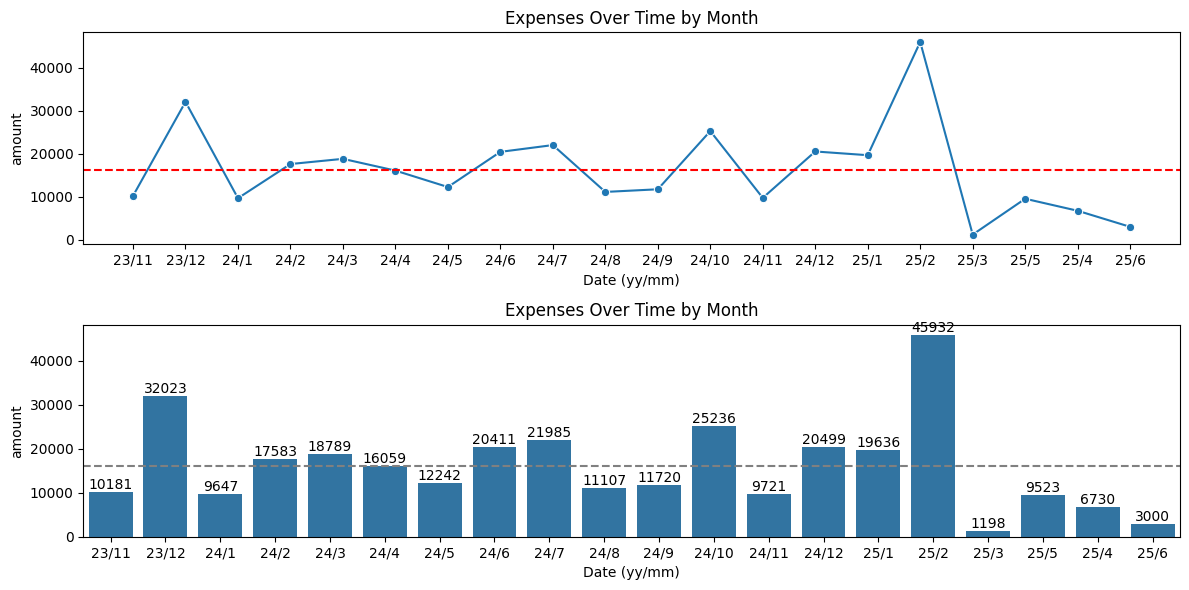

In [22]:
# Setting Mean, Median, and Standard Deviation of Monthly Expenses
stats_monthly_expen = StatsSummary(grpby_expen_by_month['amount'])

# Subplots Setting
fig, ax = plt.subplots(2, 1, figsize=(12, 6)) 

# Line Plotting with Average Horizontal Line
ax0 = sns.lineplot(data=grpby_expen_by_month, x='y/m', y='amount', marker='o', ax=ax[0])    #<- Line plot
ax0.axhline(stats_monthly_expen.mean, color='red', linestyle='--')            #<- Average line
ax0.set_title('Expenses Over Time by Month')                        
ax0.set_xlabel('Date (yy/mm)')

# Bar Plotting to Clearly See Difference
ax1 = sns.barplot(data=grpby_expen_by_month, x='y/m', y='amount', ax=ax[1])  #<- Bar plot
for bar in ax1.patches:           #<- Data labels
    height = bar.get_height()

    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', va='bottom', ha='center')

ax1.set_title('Expenses Over Time by Month')
ax1.set_xlabel('Date (yy/mm)')
ax1.axhline(y=stats_monthly_expen.mean, color='gray', linestyle='--')     #<- Average expenses line
plt.tight_layout()

# Terminal Output
print('Mean and Std of Monthly Expenses:')
stats_monthly_expen.print_stats(round_digit=3)
grpby_expen_by_month['amount'].describe()

### **Descriptive Interpretation**
**Line Graph**
- There are less variation of expenses from Feb. 2024 to Sept. 2024 compared to from Nov. 2023 to Jan. 2024, and Oct. 2024 to March 2025.
    - This might due to the festive, Christmas and New Year's seasons.

**Bar Graph**
- The largest expenses on these months is Feb. 2024.
    - Purchasing new laptop that costs ~Php 34,900 contributed largely to get this high expenses.

In [23]:
df.loc[df['details'] == 'laptop (acer aspire 3 15)', ['date', 'details', 'amount', 'transaction']]

,date,details,amount,transaction
694,2025-02-15,laptop (acer aspire 3 15),34880.0,Expenses


### **Monthly Expenses Distribution**

In [24]:
grpby_expen_by_month['amount']

0     10181.0
1     32023.0
2      9647.0
6     17583.0
7     18789.0
8     16059.0
9     12242.0
10    20411.0
11    21985.0
12    11107.0
13    11720.0
3     25236.0
4      9721.0
5     20499.5
14    19636.4
15    45932.0
16     1198.0
18     9523.0
17     6730.0
19     3000.0
Name: amount, dtype: float64

skew: 1.1676247491992067


count       20.000000
mean     16161.145000
std      10317.314762
min       1198.000000
25%       9702.500000
50%      14150.500000
75%      20433.125000
max      45932.000000
Name: amount, dtype: float64

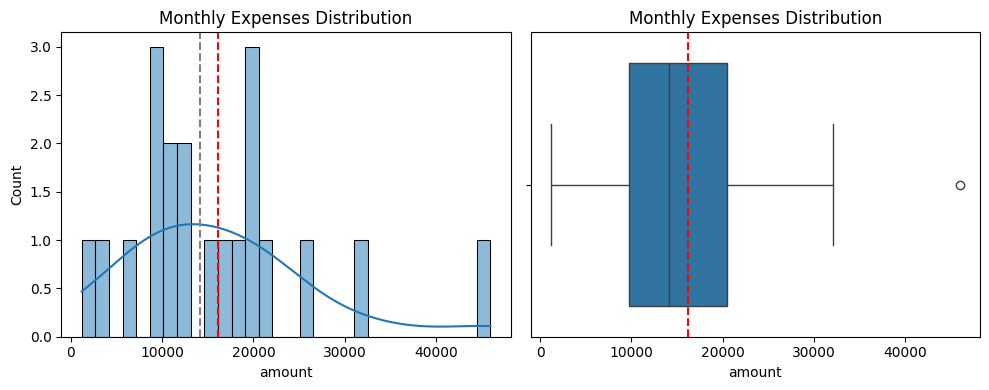

In [25]:
# Distribution Check with Distribution Plot
dict_data_expen = {'Monthly Expenses Distribution': grpby_expen_by_month['amount']}
plot_distribution(dataset=dict_data_expen, fig_size=(10, 4))

print('skew:', scistat.skew(grpby_expen_by_month['amount']))

# Terminal Output
stats_monthly_expen.stat_summary

### **Descriptive Interpretation**
- The distribution is **skewed to the right**.
    - Indicated by approximately **1.23 skewness** and mean (red line) is larger than the median (black line).
    - Total monthly expenses **between 9,000 to 20,000 is the "usual" range** of monthly expenses.
    - There is an average variation of ~Php 10,000 of monthly expenses.

### Regression Plot

Text(0.5, 0, 'Months passes over time')

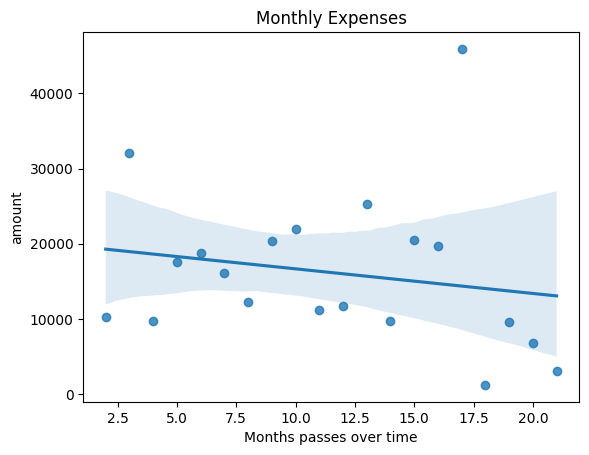

In [26]:
# Regression Plot
sns.regplot(data=grpby_expen_by_month, x=grpby_expen_by_month['date sort no.'], y='amount')
plt.title('Monthly Expenses')
plt.xlabel('Months passes over time')

### Linear Regression Test
Checking regression line's accuracy 

In [27]:
# Checking Regression Line's Accuracy
reg_expen = scistat.linregress(x=grpby_expen_by_month['date sort no.'], y=grpby_expen_by_month['amount'])  #<- Regression
slope_expen = reg_expen.slope               #<- slope (rate of change as x changes)
intercept_expen = reg_expen.intercept       #<- y-intercept

# Terminal Output
print(f"y = {slope_expen:.3f}x + {intercept_expen:.3f}")
print(f"R = {reg_expen.rvalue: .3f}")
print(f"R^2 = {reg_expen.rvalue ** 2: .3f}")

y = -327.667x + 19929.314
R = -0.188
R^2 =  0.035


In [28]:
# Appending Predictions and Residuals for Better Data Visualization
y_pred = (grpby_expen_by_month['date sort no.'] * slope_expen) + intercept_expen   #<- y prediction calculation 
resid = grpby_expen_by_month['amount'] - y_pred                         #<- Residuals calculation

grpby_expen_by_month['y pred'] = y_pred       #<- Appending y prediction
grpby_expen_by_month['resid'] = resid         #<- Appending residuals
grpby_expen_by_month

,y/m,amount,date sort no.,y pred,resid
0,23/11,10181.0,2,19273.980000,-9092.980000
1,23/12,32023.0,3,18946.313158,13076.686842
2,24/1,9647.0,4,18618.646316,-8971.646316
6,24/2,17583.0,5,18290.979474,-707.979474
7,24/3,18789.0,6,17963.312632,825.687368
8,24/4,16059.0,7,17635.645789,-1576.645789
9,24/5,12242.0,8,17307.978947,-5065.978947
10,24/6,20411.0,9,16980.312105,3430.687895
11,24/7,21985.0,10,16652.645263,5332.354737
12,24/8,11107.0,11,16324.978421,-5217.978421


Text(0, 0.5, 'Residuals')

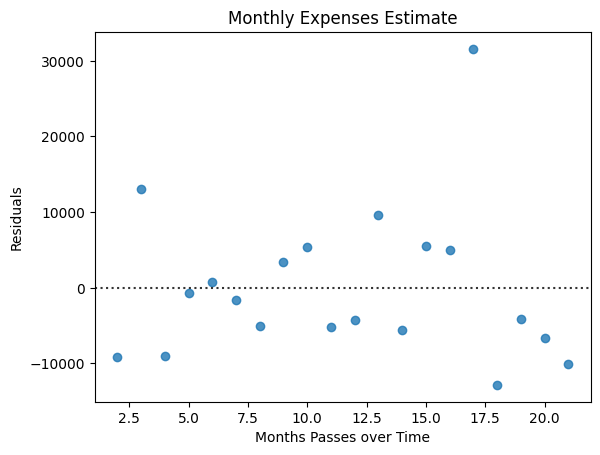

In [29]:
# Residual Plotting to Check How Scattered the Estimate Around the Model
sns.residplot(data=grpby_expen_by_month, x=grpby_expen_by_month['date sort no.'], y='resid')
plt.title('Monthly Expenses Estimate')
plt.xlabel('Months Passes over Time')
plt.ylabel('Residuals')

In [30]:
# Calculating RMSE, MAE and NRME
rmse = np.sqrt(np.sum(grpby_expen_by_month['resid']**2)/len(grpby_expen_by_month['resid']))
mae = np.sum(np.abs(grpby_expen_by_month['resid'])) / len(grpby_expen_by_month['resid'])
nrme = rmse / stats_monthly_expen.mean

# Terminal Output
print('Summary of Descriptive Stats and Metric Calculation:')           #<- Descriptive Statistics
print(f" - Mean Monthly Expenses = {stats_monthly_expen.mean:.3f}")
print(f" - Standard Deviation of Monthly Expenses (std)= Php {stats_monthly_expen.std:.3f}")

print('\nRegression Metrics:')                          #<- Regression Metrics
print(f" - R^2 = {reg_expen.rvalue ** 2: .3f}")
print(f" - Root Mean Square Error (RMSE) = {rmse:.3f}")
print(f" - Mean Absolute Error (MAE) = {mae:.3f}")
print(f" - mean-Normalized Root Mean Squarer Error (NRMSE) = {nrme * 100:.2f}%\n")

print("Checking if RMSE < std:")                        #<- Check RMSE vs std
print(f' - RMSE < std = {rmse:.3f} < {stats_monthly_expen.std:.3f} =  {rmse < stats_monthly_expen.std}')

Summary of Descriptive Stats and Metric Calculation:
 - Mean Monthly Expenses = 16161.145
 - Standard Deviation of Monthly Expenses (std)= Php 10317.315

Regression Metrics:
 - R^2 =  0.035
 - Root Mean Square Error (RMSE) = 9876.980
 - Mean Absolute Error (MAE) = 7423.974
 - mean-Normalized Root Mean Squarer Error (NRMSE) = 61.12%

Checking if RMSE < std:
 - RMSE < std = 9876.980 < 10317.315 =  True


### **Interpretation:**
- ✅RMSE is less than the Standard Deviation.
    - The **model is better than using the mean to predict** a value.
- ⚠️$R^2$ value is closer to 0 than 1.
    - The model only explains very little, and a large portion is unaccounted
    - The **model isn't capturing the real signal**.
- ⚠️NRMSE is approx. 58%.
    - The average prediction error is about 58% of the target mean value.
    - This could mean that if the mean expenses is $\text{Php}\; 15,000$, then the **prediction is $\text{Php}\; 8,700$ off on average**, when accounting for large mistakes.
- ✅Residual Plot: Scattered Around the Model.
    - The model doesn't have clear structural bias.
    - The model doesn't misfitting the trend. 

#### **Overall Assessment:**
- The model is better than the mean, but it is not enough reason to safely use for precise prediction.
- Usable, but expect nothing when it comes to the precision. 

## Data Transformation Attempt: x vs. log(y)

<Axes: xlabel='date sort no.', ylabel='amount'>

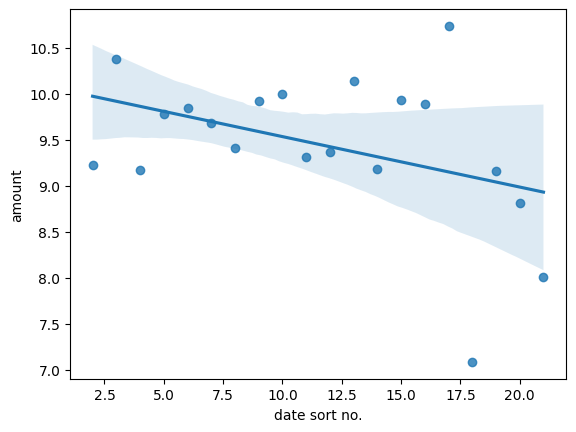

In [31]:
# Transforming Y with log() base 10
grpby_expen_by_month['log'] = np.log(grpby_expen_by_month['amount'])

# Scatter Plot Visulization with Approximate Linear Regression
sns.regplot(x=grpby_expen_by_month['date sort no.'], y=np.log(grpby_expen_by_month['amount']))

In [32]:
grpby_expen_by_month

,y/m,amount,date sort no.,y pred,resid,log
0,23/11,10181.0,2,19273.980000,-9092.980000,9.228279
1,23/12,32023.0,3,18946.313158,13076.686842,10.374210
2,24/1,9647.0,4,18618.646316,-8971.646316,9.174402
6,24/2,17583.0,5,18290.979474,-707.979474,9.774688
7,24/3,18789.0,6,17963.312632,825.687368,9.841027
8,24/4,16059.0,7,17635.645789,-1576.645789,9.684025
9,24/5,12242.0,8,17307.978947,-5065.978947,9.412628
10,24/6,20411.0,9,16980.312105,3430.687895,9.923829
11,24/7,21985.0,10,16652.645263,5332.354737,9.998116
12,24/8,11107.0,11,16324.978421,-5217.978421,9.315331


In [33]:
# Modeling log(y)
model_monthly_expen = LinearRegression()
model_monthly_expen.fit(X=grpby_expen_by_month['date sort no.'].values.reshape(-1, 1), y=grpby_expen_by_month['log'])

a = model_monthly_expen.coef_[0]            #<- Coefficient
b = model_monthly_expen.intercept_          #<- Intercept

print(f"y = e^({a:.3f}x + {b:.3f})")        #<- Terminal Output (Transformed Model)

y = e^(-0.055x + 10.081)


In [34]:
# Appending y Prediction from log and Its Residuals to the DataFrame
grpby_expen_by_month['y pred (log)'] = np.exp(a * grpby_expen_by_month['date sort no.'] + b)    #<- Calc y predictions
grpby_expen_by_month['resid (log)'] = grpby_expen_by_month['amount'] - grpby_expen_by_month['y pred (log)'] #<- Appending

grpby_expen_by_month

,y/m,amount,date sort no.,y pred,resid,log,y pred (log),resid (log)
0,23/11,10181.0,2,19273.980000,-9092.980000,9.228279,21416.286124,-11235.286124
1,23/12,32023.0,3,18946.313158,13076.686842,10.374210,20274.923729,11748.076271
2,24/1,9647.0,4,18618.646316,-8971.646316,9.174402,19194.389252,-9547.389252
6,24/2,17583.0,5,18290.979474,-707.979474,9.774688,18171.440924,-588.440924
7,24/3,18789.0,6,17963.312632,825.687368,9.841027,17203.009740,1585.990260
8,24/4,16059.0,7,17635.645789,-1576.645789,9.684025,16286.190256,-227.190256
9,24/5,12242.0,8,17307.978947,-5065.978947,9.412628,15418.231871,-3176.231871
10,24/6,20411.0,9,16980.312105,3430.687895,9.923829,14596.530575,5814.469425
11,24/7,21985.0,10,16652.645263,5332.354737,9.998116,13818.621137,8166.378863
12,24/8,11107.0,11,16324.978421,-5217.978421,9.315331,13082.169708,-1975.169708


<Axes: xlabel='date sort no.', ylabel='resid (log)'>

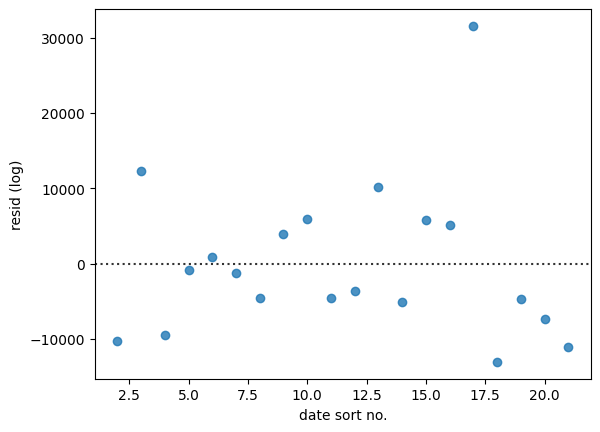

In [35]:
# Residual Plot of y Prediction
sns.residplot(x=grpby_expen_by_month['date sort no.'], y=grpby_expen_by_month['resid (log)'])

In [36]:
# Regression Metrics Calculation
r2_log = metrics.r2_score(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred (log)'])
rmse_log = metrics.root_mean_squared_error(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred (log)'])
nrmse_log = rmse_log/grpby_expen_by_month['amount'].mean()

# Terminal Output
print('Monthly Expenses Stats (Php):')              #<- Stats Summary
stats_monthly_expen.print_stats(round_digit=3)

print('\nRegression Metrics:')                      #<- Regression Metrics
print(f"R^2 = {r2_log:.3f}")
print(f"RMSE = {rmse_log:.3f}")
print(f"NRMSE = {nrmse_log:.3f}")

print('\nChecking RMSE vs. std')                    #<- Checking RMSE vs Std
print(f'RMSE < std = {rmse_log:.3f} < {stats_monthly_expen.std:.3f} =  {rmse_log < stats_monthly_expen.std}')

Monthly Expenses Stats (Php):
Mean = 16161.145
Standard Deviation = 10317.315

Regression Metrics:
R^2 = -0.121
RMSE = 10648.480
NRMSE = 0.659

Checking RMSE vs. std
RMSE < std = 10648.480 < 10317.315 =  False


### **Interpretation:**
- ⚠️RMSE is greater than standard deviation.
    - Model has more variability than predicting with mean.
    - **Mean is better for predicting than the model**.
- ⚠️ $R^2$ is negative.
    - The precision is so bad, it gone negative.
    - **Not reliable for predicting values in terms of precision**.
- ⚠️ NRMSE is approximately 62%.
    - Larger than what we would want.
    - This could mean that if the mean expenses is $\text{Php}\; 15,000$, then the **prediction is $\text{Php}\; 9,300$ off on average**, when accounting for large mistakes.
- ✅Residual Plot: Scattered arount the model.
    - The model likely have clear structural bias.
    - The model doesn't misfitting the trend.

### **Overall Assessment**
- The **prior model is better** than this one.
- **Metrics are not good enough** compared the prior model.

In [37]:
metrics.mean_absolute_error(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred (log)'])

7021.963435556095

## **Confidence Interval**
#### I want to find out what is the true monthly expenses.

skew: 1.1676247491992067


count       20.000000
mean     16161.145000
std      10317.314762
min       1198.000000
25%       9702.500000
50%      14150.500000
75%      20433.125000
max      45932.000000
Name: amount, dtype: float64

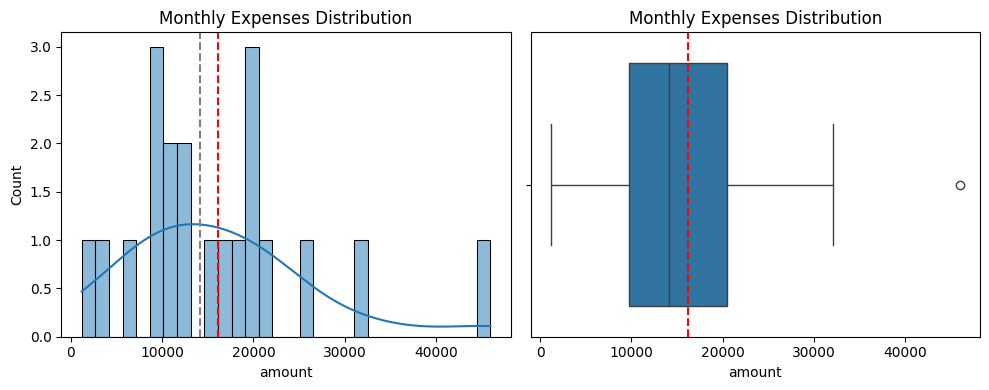

In [38]:
# Distribution Check with Distribution Plot
plot_distribution(dataset=dict_data_expen, fig_size=(10, 4))

print('skew:', scistat.skew(grpby_expen_by_month['amount']))    #<- Skewness

# Terminal Output
stats_monthly_expen.stat_summary

### **Bootstrap Confidence Interval (CI)**
- Since the distribution can't be assumed as normal.
- **Distribution is skewed to the right**.
- **Median-based inference would be better** than mean-based.

In [39]:
# Bootstrap Confidence Interval
sample = np.random.choice(grpby_expen_by_month['amount'],                               #<- Random sampling simulation 
                          size=(10_000 , len(grpby_expen_by_month['amount'])), replace=True)
btsrp_means = sample.mean(axis=1)                                   #<- Mean of samples means

ci_lower = np.percentile(btsrp_means, ((1 - .95)/2) * 100)          #<- Lower interval
ci_upper = np.percentile(btsrp_means, (1 - ((1 - .95)/2)) * 100)    #<- Upper interval

approx_moe = (ci_upper - ci_lower) / 2                              #<- MOE approximation

# Terminal Output
print(f"95% Bootstrap CI = ({ci_lower:.3f}, {ci_upper:.3f})")

95% Bootstrap CI = (12129.255, 20918.883)


##### **Interpretation:**
- I am 95% confident that the true average monthly expenses lies within those interval.
    - I can't put the values of those interval as they change as I enter new data. 

### **Bootstrapping Visualization:**

Text(0.5, 0, 'Means')

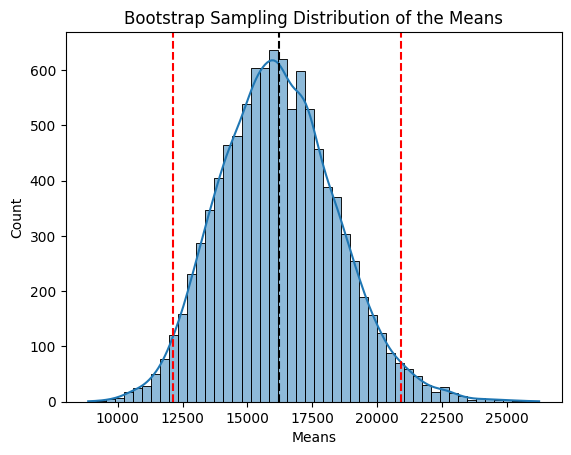

In [40]:
# Histogram Plotting
sns.histplot(btsrp_means, bins=50, kde=True)            #<- Histogram setting
plt.axvline(btsrp_means.mean(), color='black', linestyle='--')  #<- Mean line (black)

for ci in [ci_lower,  ci_upper]:                        #<- CI line (red)
    plt.axvline(ci, color='red', linestyle='--')

plt.title('Bootstrap Sampling Distribution of the Means')
plt.xlabel('Means')

### Giving Context on the Bootstrap Confidence Interval

In [41]:
# Comparing CI to Mean and Standard Deviation for Context
print(f"Average Monthly Expenses = Php {stats_monthly_expen.mean:.3f}")                             #<- Mean
print(f"Average Spread from the Mean (Standard Deviation) = Php {stats_monthly_expen.std:.3f}")     #<- Std
print(f"Bootstrap Confidence Interval (CI) = ({ci_lower:.3f}, {ci_upper:.3f})\n")                   #<- CI

# Margin of Error
print(f"Approximate Margin of Error (MOE) = {approx_moe:.3f}")                                      #<- MOE
print(f"% of MOE against the Mean = {approx_moe / stats_monthly_expen.mean * 100:.2f}%")            #<- MOE / mean
print(f"% of MOE against the Standard Deviation = {approx_moe / stats_monthly_expen.std * 100: .2f}%")  #<- MOE / Std

Average Monthly Expenses = Php 16161.145
Average Spread from the Mean (Standard Deviation) = Php 10317.315
Bootstrap Confidence Interval (CI) = (12129.255, 20918.883)

Approximate Margin of Error (MOE) = 4394.814
% of MOE against the Mean = 27.19%
% of MOE against the Standard Deviation =  42.60%


#### **Interpretation:**
📝$\text{1.}$ Margin of Error:
- MOE says that we have that amount of **uncertainty either the true monthly expenses is 4000 below or above** from our average estimate.

👍$\text{2.}$ Relative MOE $(\frac{\text{MOE}}{\text{mean}})$:
- There's **26% MOE against to mean**.
- Tells us if MOE is going to be larger than the mean.
- If greater than or equal to Mean, CI has low precision of estimating the true average of monthly expenses.
- **26% is acceptable, but interpret it with caution.**

👌$\text{3.}$ CI width Against Standard Deviation $(\frac{\text{MOE}}{\text{std}})$:
- There's **44% MOE against to standard deviation** (std).
- Tells us the overall spread (or noise) of MOE compared to standard deviation.
- How informative or vague the estimate of CI.
- If greater than or equal to std, CI is too vague to estimate the true monthly expenses.
- **44% is somewhat vague. It is not tight, but not horrible either.**

**Overall Interpretation:**
- The Confidence Interval is neither good or bad. **Acceptable range but interpret with caution**.
- Uncertainty and vagueness might due to the original data distribution itself.
    - Right skewed, small sample size of 19, and high variability.
    - t statistic-based CI may perform worse, that's why bootstrap CI is worth trying for.

### **Daily Expenses** 
`transaction` == `Expenses` and `amount`

In [42]:
# Setting Daily Expenses DataFrame
df_daily_expen = df_expenses.groupby('y/m/d')['amount'].sum().reset_index()

# Descriptive Statistics Summary
stats_daily_expen = StatsSummary(df_daily_expen['amount'])

# Terminal Output
print('Daily Expenses Statistic Summary (in Php):')
stats_daily_expen.print_stats(round_digit=3)

df_daily_expen

Daily Expenses Statistic Summary (in Php):
Mean = 1346.762
Standard Deviation = 3265.529


,y/m/d,amount
0,23/11/10,73.0
1,23/11/13,162.0
2,23/11/14,25.0
3,23/11/15,125.0
4,23/11/16,55.0
...,...,...
235,25/5/2,613.0
236,25/5/22,320.0
237,25/5/3,5150.0
238,25/5/4,3000.0


#### **Data Distribution Check**

Skewness: 6.407


,index,amount
0,count,240.000000
1,mean,1346.762083
2,std,3265.529145
3,min,5.000000
4,25%,125.000000
5,50%,249.500000
6,75%,770.750000
7,max,37359.000000


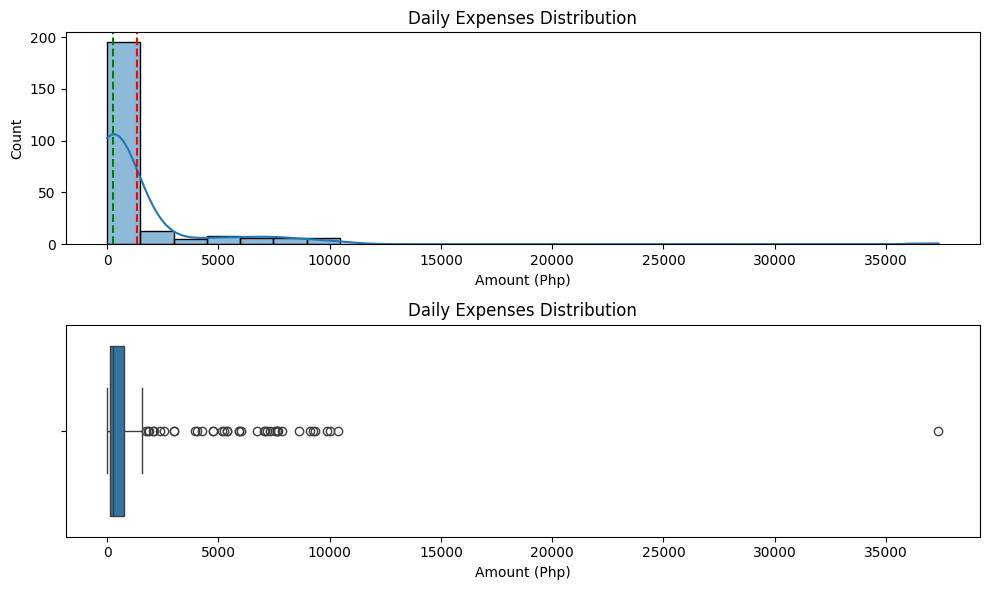

In [43]:
# Distribution Check Using Histogram and Boxplot in Subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Histogram
ax1 = sns.histplot(stats_daily_expen.data, kde=True, bins=25, ax=ax[0])               #<- Histogram Setting
ax1.set_title('Daily Expenses Distribution')                                            #<- Title
ax1.axvline(stats_daily_expen.mean, label='mean', color='red', linestyle='--')          #<- Mean line (red)
ax1.axvline(stats_daily_expen.median, label='median', color='green', linestyle='--')    #<- Median line (green)
ax1.set_xlabel('Amount (Php)')

# Boxplot
ax2 = sns.boxplot(x=stats_daily_expen.data, ax=ax[1])     #<- Boxplot Setting
ax2.set_title('Daily Expenses Distribution')              #<- Title
ax2.set_xlabel('Amount (Php)')                            #<- xlabel

plt.tight_layout()

# Terminal Output
print(f"Skewness: {scistat.skew(stats_daily_expen.data):.3f}")
stats_daily_expen.stat_summary.reset_index()

#### **Descriptive Interpretation**:
**Histplot**
- The distribution is skewed to the right.
    - **Usual daily expenses are less than 5000**, even 2500.
- The red vertical line is the mean of my daily expenses.
    - The average daily expenses, for over several days.
- The green vertical line is the **median of my daily expenses**.
    - It is the middle value of all data of my expenses.
    - It is **better daily expenses estimate** since the distribution is overly skewed to the right.

**Boxplot**
- The distribution is located to the left side of the plot.
    - The distribution is skewed to the left.
    - The box is where my most common daily expenses lands.
    - Narrow box means **consistently repeated data record**.
- There are many outliers in the distribution.
    - The **unusual daily expenses**.
    - Might need to transform this data for further inference.

## `Income` Analysis

In [44]:
# Extracting Income Data and Making Separate DF
df_income = df[df['transaction'] == 'Income']

# Group by `y/m` and Sum their Amount
grpby_income = df_income.groupby('y/m')['amount'].sum().reset_index()

map_month = df.loc[:, ['y/m', 'month sort no.']].drop_duplicates().set_index('y/m').to_dict()['month sort no.'] #<- Mapping dict
grpby_income['month sort no.'] = grpby_income['y/m'].map(map_month)                                             #<- Appeding mapping to Df
grpby_income = grpby_income.sort_values(by='month sort no.').set_index('month sort no.')                        #<- Sorting values

# Setting Stats Summary of Monthly Income
stats_monthly_income = StatsSummary(grpby_income['amount'])

grpby_income

,y/m,amount
month sort no.,,
0,23/9,17732.0
1,23/10,25588.0
2,23/11,70026.0
3,23/12,43465.0
4,24/1,25466.0
5,24/2,25195.0
6,24/3,25195.0
7,24/4,32231.0
8,24/5,52230.0


Monthly Income Statisitc Summary (in Php):
Mean = 32593.0
Standard Deviation = 17994.312
Median = 27502.0


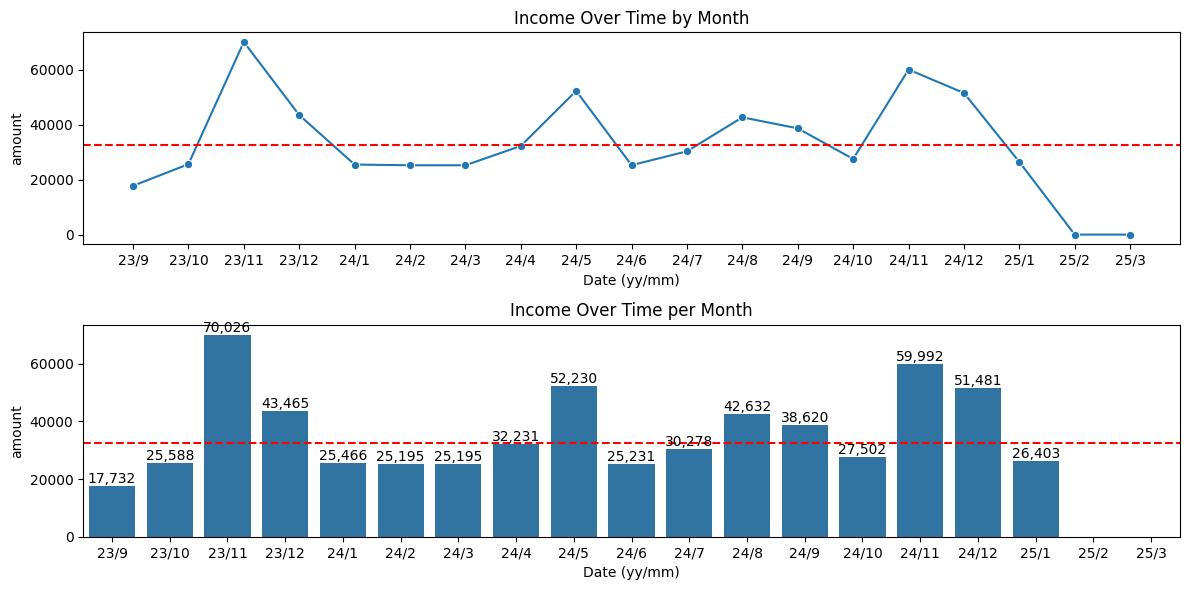

In [45]:
# Setting Subplot
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Line Plotting Monthly Income
ax0 = sns.lineplot(data=grpby_income, x='y/m', y='amount', marker='o', ax=ax[0])    #<- Line plot
ax0.set_title('Income Over Time by Month')
ax0.set_xlabel('Date (yy/mm)')
ax0.axhline(stats_monthly_income.mean, color='red', linestyle='--')   #<- Mean line

# Bar Plot
ax1 = sns.barplot(data=grpby_income, x='y/m', y='amount')    #<- Bar plot
for bar in ax1.patches:                                      #<- Data labels
    height = bar.get_height()

    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', va='bottom', ha='center')

ax1.set_title('Income Over Time per Month')
ax1.set_xlabel('Date (yy/mm)')
ax1.axhline(stats_monthly_income.mean, color='red', linestyle='--')   #<- Mean line

# Terminal Output
print("Monthly Income Statisitc Summary (in Php):")
stats_monthly_income.print_stats(median=True, round_digit=3)

plt.tight_layout()

#### **Descriptive Interpretation:**
**Line Graph**
- Income are at **highest during November and December** of the year.
    - Could be **caused by $13th$ month pay and other incentives**.
    - The same as on March. Can be because of mid-year bonus.
- February and March has 0 income.
    - Those are** months I no longer work** and **started to properly study about data analysis**.
- Because of these fluctuations, the monthly income has average variation of approximately $\text{Php}\;18,000$.

**Bar Graph**
- **Nov. of 2023, Nov.** and **Dec. of 2024** had higher income.
    - These are months where **there are some other source of income other than teaching**.
    - Might be the **reason why there's a large variation of monthly income**.

### **Monthly Income Distribution**

Skewness = 0.147


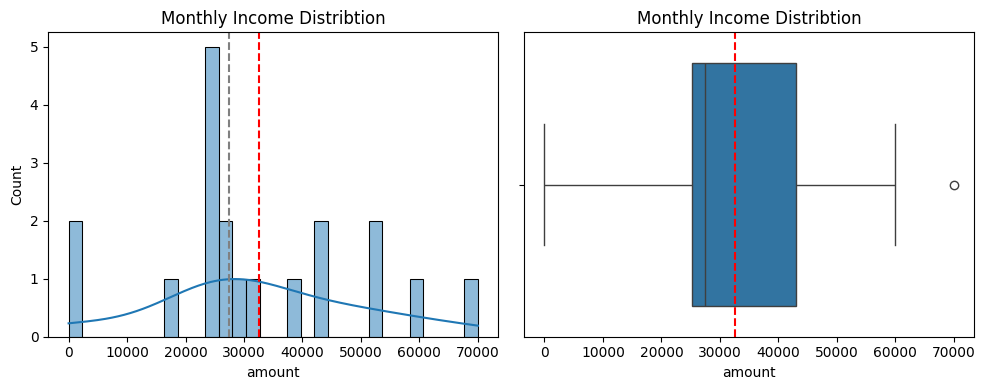

In [46]:
# Distribution Plot for Monlthy Income 
dict_data_income = {'Monthly Income Distribtion': stats_monthly_income.data}
plot_distribution(dataset=dict_data_income)

# Checking Skewness
print(f"Skewness = {scistat.skew(stats_monthly_income.data):.3f}")

#### **Descriptive Interpretation:**
- The distribution is **roughly normal**.
    - Skewness is **approximately 0.15**, almost 0, **safe to assume it is roughly normal**.

Text(0.5, 0, 'Month Passes over Time')

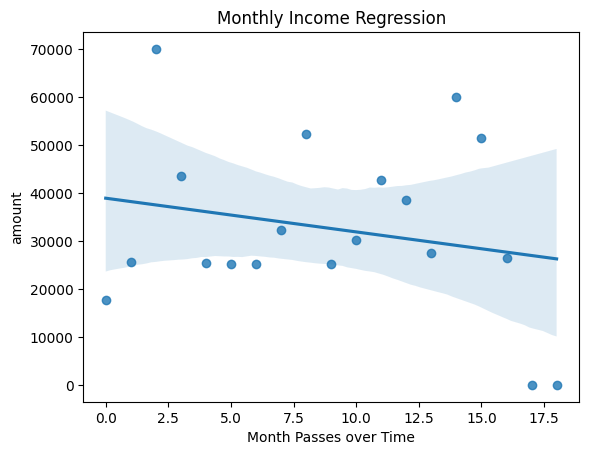

In [47]:
# Regression plot
sns.regplot(data=grpby_income, x=grpby_income.index, y='amount')
plt.title('Monthly Income Regression')
plt.xlabel('Month Passes over Time')

In [48]:
# Getting Slope and Intercep Value of Regression Line
reg_income = scistat.linregress(x=grpby_income.index, y=grpby_income['amount']) #<- Reg. line
slope_income = reg_income.slope                 #<- slope
intercept_income = reg_income.intercept         #<- y-intercept

# Terminal Output
print(f"y = {slope_income:.3f}x + {intercept_income:.3f}")
print(f"R = {reg_income.rvalue:.3f}")
print(f"R^2 = {reg_income.rvalue **2 :.3f}")

y = -702.761x + 38917.853
R = -0.220
R^2 = 0.048


In [49]:
# Amount Estimate and Residual Calcualtion
y_pred = (grpby_income.index * slope_income) + intercept_income   #<- Monthly income amount esimate
resid = grpby_income['amount'] - y_pred                         #<- Residuals

# Appending Monthly Amount Income Estimate and Residuals
grpby_income['y pred'] = y_pred     #<- Monthly Amount Income
grpby_income['resid'] = resid       #<- Residuals
grpby_income

,y/m,amount,y pred,resid
month sort no.,,,,
0,23/9,17732.0,38917.852632,-21185.852632
1,23/10,25588.0,38215.091228,-12627.091228
2,23/11,70026.0,37512.329825,32513.670175
3,23/12,43465.0,36809.568421,6655.431579
4,24/1,25466.0,36106.807018,-10640.807018
5,24/2,25195.0,35404.045614,-10209.045614
6,24/3,25195.0,34701.284211,-9506.284211
7,24/4,32231.0,33998.522807,-1767.522807
8,24/5,52230.0,33295.761404,18934.238596


Text(0.5, 0, 'Months Passese over Time')

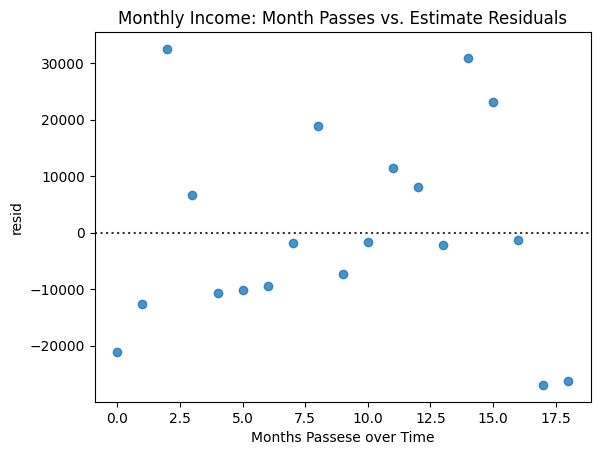

In [50]:
# Residual Plot
sns.residplot(x=grpby_income.index, y=grpby_income['resid'])
plt.title('Monthly Income: Month Passes vs. Estimate Residuals')
plt.xlabel('Months Passese over Time')

#### **Regression Metrics Assessment:**

In [51]:
# Regression Metrics Assessment
r2 = metrics.r2_score(y_true=grpby_income['amount'], y_pred=grpby_income['y pred'])
rmse = metrics.root_mean_squared_error(y_true=grpby_income['amount'], y_pred=grpby_income['y pred'])
mae = metrics.mean_absolute_error(y_true=grpby_income['amount'], y_pred=grpby_income['y pred'])
nrmse = rmse / stats_monthly_income.mean

# Terminal Output
print('Mean and Standard Deviation (Php):')                 #<- Mean and Std
stats_monthly_income.print_stats(round_digit=2)

print('\nRegression Metrics:')                              #<- Regression Metrics
print(f"- R^2 = {r2:.3f}")
print(f"- RMSE = {rmse:,.3f}")
print(f"- MAE = {mae:,.3f}")
print(f"- NRME = {nrme:.3f}")

print('\nCheck RMSE < std:')                                #<- Check RMSE < std
print(f'- RMSE < std = {rmse < stats_monthly_income.std}')

Mean and Standard Deviation (Php):
Mean = 32593.0
Standard Deviation = 17994.31

Regression Metrics:
- R^2 = 0.048
- RMSE = 17,086.170
- MAE = 13,863.213
- NRME = 0.611

Check RMSE < std:
- RMSE < std = True


### **Interpretation:**
- ✅RMSE is less than the Standard Deviation.
    - The **model is better than using the mean to predict** a value.
- ⚠️$R^2$ value is closer to 0 than 1.
    - The model only explains very little, and a large portion is unaccounted
    - The **model isn't capturing the real signal**.
- ⚠️NRMSE is approx. 58%.
    - The average prediction error is about 58% of the target mean value.
    - Since the mean income is $\text{Php}\; 32,600$, then the **prediction is $\text{Php}\; 18,850$ off on average**, when accounting for large mistakes.
- ✅Residual Plot: Scattered Around the Model.
    - The model doesn't have clear structural bias.
    - The model doesn't misfitting the trend. 

#### **Overall Assessment:**
- The **model is better than the mean** for estimation, but it is **not enough reason to safely rely in this model for precise prediction**.
- Usable, but expect nothing when it comes to the precision. 

## `G-cash` Transaction Mode

In [52]:
# Setting Gcash Expenses DataFrame
df_gcash = df[df['transaction_mode'] == "G-cash"]                       #<- Filtering Gcash only transactions
df_gcash_expen = df_gcash[df_gcash['transaction'] == 'Expenses']        #<- Filtering expenses only in gcash transactions

gcash_monthly_expen = df_gcash_expen.groupby('y/m')['amount'].sum().reset_index()   #<- Grouping by month

gcash_monthly_expen['month sort no.'] = gcash_monthly_expen['y/m'].map(map_month)   #<- Mapping by month
gcash_monthly_expen = gcash_monthly_expen.sort_values(by='month sort no.')          #<- Sorting by month

# Setting Summary Stat of Gcash Monthly Expenses
stats_gcash_expen = StatsSummary(gcash_monthly_expen['amount'])                             #<- Stats Summary Gcash expenses

# Terminal Output
gcash_monthly_expen

,y/m,amount,month sort no.
0,23/11,1003.0,2
1,23/12,2663.0,3
2,24/1,1957.0,4
5,24/2,2692.0,5
6,24/3,1746.0,6
7,24/4,2246.0,7
8,24/5,1970.0,8
9,24/6,2998.0,9
10,24/7,2903.0,10
11,24/8,1762.0,11


Summary Statistics: 
count      13.000000
mean     1961.846154
std       782.393214
min       199.000000
25%      1746.000000
50%      1957.000000
75%      2663.000000
max      2998.000000
Name: amount, dtype: float64

Skewness = -0.675


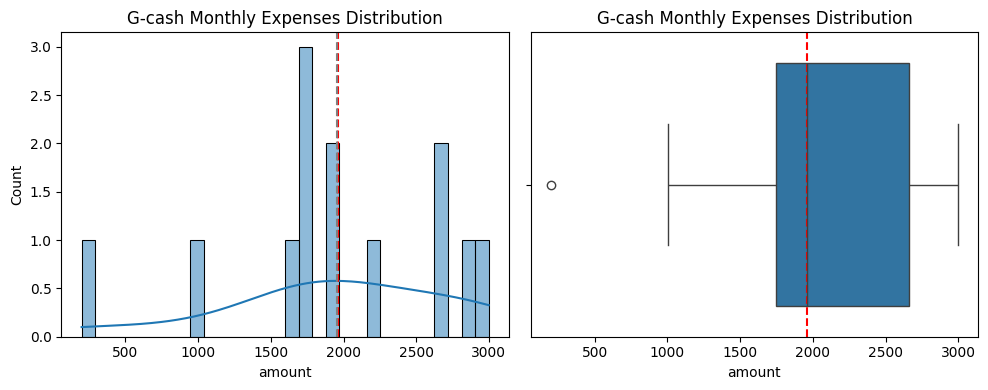

In [53]:
dict_gcash_monthly_expen = {'G-cash Monthly Expenses Distribution': gcash_monthly_expen['amount']}
plot_distribution(dict_gcash_monthly_expen)

print(f"Summary Statistics: \n{stats_gcash_expen.stat_summary}")

print(f"\nSkewness = {scistat.skew(stats_gcash_expen.data):.3f}")

### **Descriptive Interpretation**
- The distribution is **skewed to the left**.
    - Indicated by approximately **-0.68 skewness**.
    - Total monthly expenses **between 1,700 to 2,700 becames the "usual" range** of monthly expenses.
    - There is an average variation of ~Php 800 of monthly expenses.

#### **G-cash Expenses Data Plotting**

Mean and Standard Deviation of G-cash Monthly Expenses (Php):
Mean = 1961.85
Standard Deviation = 782.39


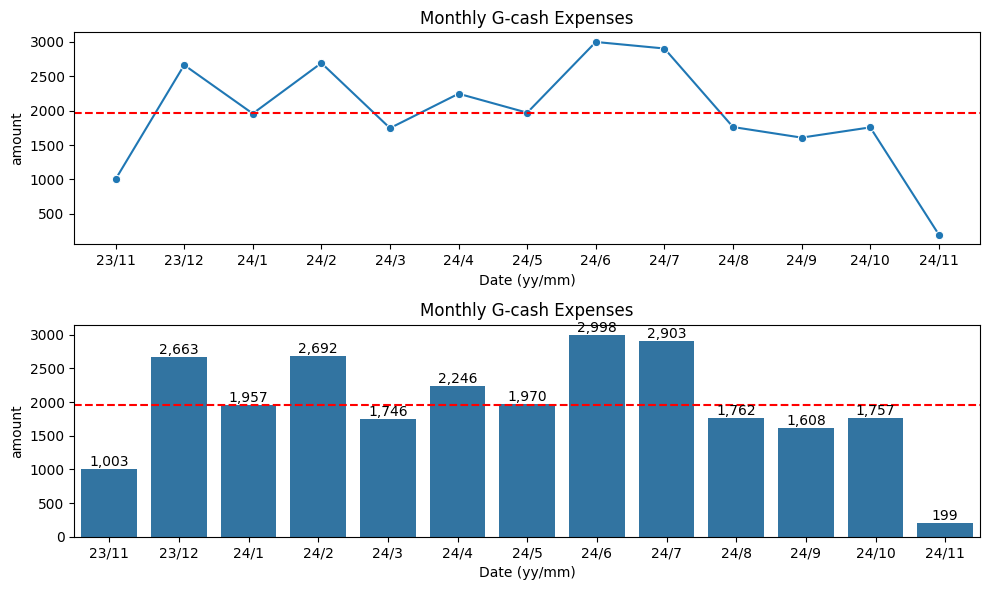

In [54]:
# Setting Subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Line Plotting Monthly Expenses Using Gcash
ax1 = sns.lineplot(data=gcash_monthly_expen, x='y/m', y='amount', marker='o', ax=ax[0])     #<- Line plot
ax1.axhline(stats_gcash_expen.mean, color='red', linestyle='--')                            #<- Mean line
ax1.set_title('Monthly G-cash Expenses')                                                    #<- Title
ax1.set_xlabel('Date (yy/mm)')                                                              #<- xlabel

# Bar Plot
ax2 = sns.barplot(data=gcash_monthly_expen, x='y/m', y='amount')                            #<- Bar plot
for bar in ax2.patches:                                                                     #<- Data label
    height = bar.get_height()

    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', va='bottom', ha='center')

ax2.axhline(stats_gcash_expen.mean, color='red', linestyle='--')                            #<- Mean line
ax2.set_title('Monthly G-cash Expenses')                                                    #<- Title
ax2.set_xlabel('Date (yy/mm)')                                                              #<- xlabel

plt.tight_layout()

# Terminal Output
print('Mean and Standard Deviation of G-cash Monthly Expenses (Php):')
stats_gcash_expen.print_stats(round_digit=2)

### **Grouping by G-cash Transactions** (Monthly)

In [55]:
# Grouping by Monthly Expenses Transactions
gcash_monthly_transac_expen = df_gcash_expen.groupby(['detail_clean', 'y/m'])['amount'].agg(['sum', 'mean', 'count']).reset_index()

# Aggregating Grouped by G-cash Monthly Expenses Transactions
aggr_gcash_month_trans_expen = gcash_monthly_transac_expen.groupby(['detail_clean'])['sum'].agg(['mean', 'std', 'median', 'count', 'sum']).reset_index()
aggr_gcash_month_trans_expen

,detail_clean,mean,std,median,count,sum
0,Genshin Welkin,280.000000,0.000000,280.0,7,1960.0
1,Membership gift,258.000000,NaN,258.0,1,258.0
2,Palaman peanut,500.000000,NaN,500.0,1,500.0
3,Sheena,150.000000,NaN,150.0,1,150.0
4,Spotify,235.250000,12.990381,239.0,12,2823.0
5,Steam,341.000000,332.231847,188.0,5,1705.0
6,Supa,512.833333,353.629193,377.0,12,6154.0
7,YT Membership,129.000000,0.000000,129.0,10,1290.0
8,YT sticker,15.000000,NaN,15.0,1,15.0
9,bag,1000.000000,NaN,1000.0,1,1000.0


In [56]:
# Setting DataFrame for Mean per Purchase Months, Monthly Total Expenses, and Expected Monthly Cost 
num_of_months = df_gcash_expen['y/m'].nunique()     #<- Number of Months (earliest record to latest)

others = aggr_gcash_month_trans_expen[aggr_gcash_month_trans_expen['count'] < 2]        #<- Empty amount list for <1 transaction count
regulars = aggr_gcash_month_trans_expen[aggr_gcash_month_trans_expen['count'] >= 2]     #<- Empty total expenses list for <1 transaction count

clean_df_gcash = regulars.loc[:, ['detail_clean', 'mean', 'sum', 'count']]              #<- Filtering "regulars" DataFrame
clean_df_gcash.sort_values(by='sum', ascending=False)

,detail_clean,mean,sum,count
6,Supa,512.833333,6154.0,12
14,wifi load (magic data),642.000000,4494.0,7
13,wifi load (family access),361.909091,3981.0,11
4,Spotify,235.250000,2823.0,12
0,Genshin Welkin,280.000000,1960.0,7
5,Steam,341.000000,1705.0,5
7,YT Membership,129.000000,1290.0,10


In [57]:
# Cleaning and Filtering "others"  
dict_others_gcash = others.loc[:, 'sum'].describe().to_dict()                                   #<- Setting "others" dict
df_others_gcash = pd.DataFrame([{'detail_clean': 'Others', 'mean': dict_others_gcash['mean'],   #<- Setting "others" to DataFrame
                           'sum': others['sum'].sum(), 'count': dict_others_gcash['count']}])

# Appending "others" to "regulars" Df
if df_others_gcash['detail_clean'][0] not in clean_df_gcash['detail_clean'].to_list():          #<- Avoids appending duplicate
    clean_df_gcash2 = pd.concat([clean_df_gcash, df_others_gcash], ignore_index=True)           #<- Appending "others" to "regulars"

# Renaming Columns and Appending Expected Monthly Cost
clean_df_gcash2.columns = ['details', 'mean per purchase months', 'total expenses', 'transaction count']
clean_df_gcash2['E(monthly cost)'] = clean_df_gcash2['total expenses'] / num_of_months

clean_df_gcash2

,details,mean per purchase months,total expenses,transaction count,E(monthly cost)
0,Genshin Welkin,280.000000,1960.0,7.0,150.769231
1,Spotify,235.250000,2823.0,12.0,217.153846
2,Steam,341.000000,1705.0,5.0,131.153846
3,Supa,512.833333,6154.0,12.0,473.384615
4,YT Membership,129.000000,1290.0,10.0,99.230769
5,wifi load (family access),361.909091,3981.0,11.0,306.230769
6,wifi load (magic data),642.000000,4494.0,7.0,345.692308
7,Others,387.125000,3097.0,8.0,238.230769


Number of Months Recorded (from earliest to lates) = 13 Months


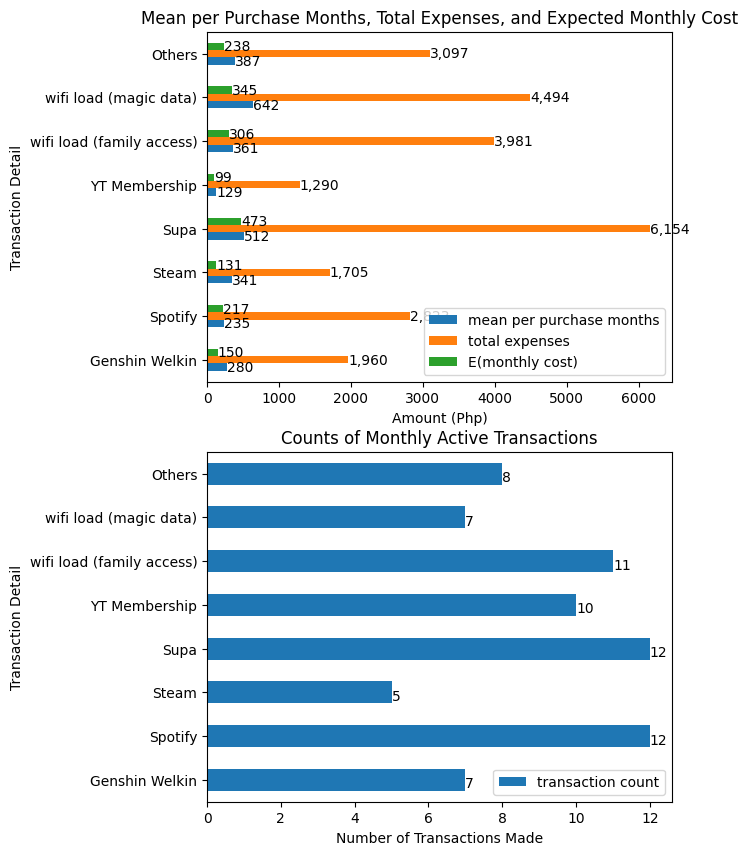

In [58]:
# Data Visualization for Mean per Purchase Months, Total Expenses, and Expected Monthly Cost
fig, ax = plt.subplots(2, 1, figsize=(6, 10))

# Horizontal Bar Plot of Mean per Purchase Months and Expected Monthly Cost
ax0 = clean_df_gcash2.plot(kind='barh', x='details', y=['mean per purchase months', 'total expenses', 'E(monthly cost)'], ax=ax[0])
for bar in ax0.patches:
    width = bar.get_width()
    ax0.text(x=width, y=bar.get_y() - bar.get_height()/2, s=f'{int(width):,}', va='bottom', ha='left')
ax0.set_xlabel('Amount (Php)')
ax0.set_ylabel('Transaction Detail')
ax0.set_title('Mean per Purchase Months, Total Expenses, and Expected Monthly Cost')

# Horizontal Bar Plot of Expected Monthly Cost
ax1 = clean_df_gcash2.plot(kind='barh', x='details', y='transaction count', ax=ax[1])
for bar in ax1.patches:
    width = bar.get_width()
    ax1.text(x=width, y=bar.get_y(), s=f'{int(width):,}', va='bottom', ha='left')
ax1.set_xlabel('Number of Transactions Made')
ax1.set_ylabel('Transaction Detail')
ax1.set_title('Counts of Monthly Active Transactions')

# Terminal Output
print(f"Number of Months Recorded (from earliest to lates) = {num_of_months} Months")

### **Descriptive Interpretation:**
##### **Total Expenses**  
- The total expenses recorded from its first record to latest.
- **"Supa" has the highest expenditure recorded amount** up to date.

##### **Mean of Purchase Months**  
- Average monthly active purchases.
- Compuation does not include months where there's no purchases.
    - "Supa" has approximately $\text{Php}\: 5,000$ average monthly active expenses.

##### **Expected Monthly Cost**
- An **amount where expenses approaches as number of attempts increases**.
- Might be lower than the mean of purchase months since it includes months where it spends nothing (zero purchase) in the computation.
- "Others" has large variation of expenses amount, but knowing the expected monthly expenses could lessen the uncertainty.
    - **"Others" expenses will be around $\text{Php}\: 240$ next month**.

##### **Transaction Counts**
- Counts of how many months we have recorded of spending (at least once in a month).
    - Buying a wifi load ***once*** in a given month will count as ***1 active month*** of spending.
    - Buying a wifi load ***twice*** in a given month will still count as ***1 active month*** of spending.
    - Buying ***not even once*** in a given month ***won't count as an active month*** of spending.
    - There are **60+ times I bought "Supa" throughout the record**, but **12 months are considered active**, since I bought it at least once a month.
- **I spend "Supa" and "Spotify" almost every month**.
    - One of the most frequent monthly purchases.

# **Hypothesis Testing**
### **Question 1:**  
#### Is it unusual to to have less than or equal to $\text{Php}\: 10,000$ monthly expenses?

$H_0:$ **Not unusual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.  
$H_A:$ **It is unusual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.  
$\alpha = 0.05$

#### **Non-parametric Hypothesis Testing will be used**.
- The monthly expenses data is **not normally distributed**.

skew: 1.1676247491992067


count       20.000000
mean     16161.145000
std      10317.314762
min       1198.000000
25%       9702.500000
50%      14150.500000
75%      20433.125000
max      45932.000000
Name: amount, dtype: float64

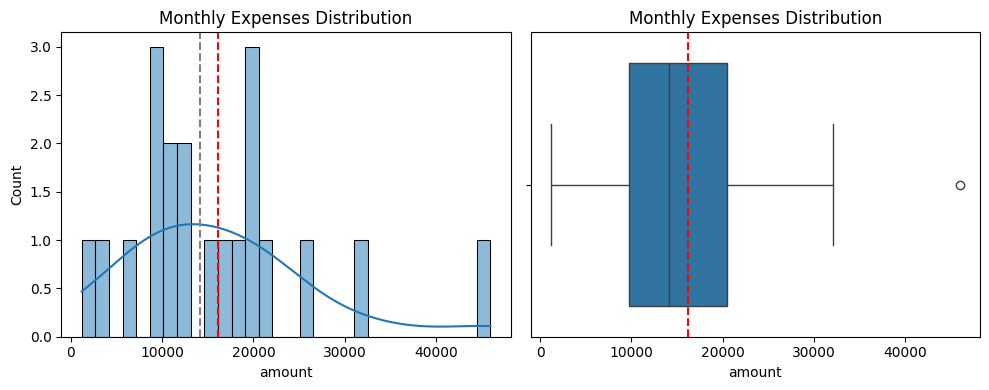

In [59]:
# Distribution Check with Distribution Plot
dict_data_expen = {'Monthly Expenses Distribution': grpby_expen_by_month['amount']}
plot_distribution(dataset=dict_data_expen, fig_size=(10, 4))

print('skew:', scistat.skew(grpby_expen_by_month['amount']))

# Terminal Output
stats_monthly_expen.stat_summary

In [60]:
# Functions 
def interpret_pvalue(pvalue: float, alpha: float = 0.05) -> bool:
    """Checks if alpha (significance level) is less than the p-value (*default: 0.05*)."""

    if alpha < pvalue:
        print(f"Fail to Reject Null Hypothesis. alpha < p-value ({alpha} < {pvalue:.2f})")
    else:
        print(f"Reject Null Hypothesis. alpha > p-value ({alpha} > {pvalue:.2f})")


# Non-parametric Hypothesis Testing
assumed = 10_000                                                #<- Assumed number
diff = [x - assumed for x in grpby_expen_by_month['amount']]    #<- List of difference of data and assumed (x - assumed)
pos = sum(d > 0 for d in diff)                                  #<- Number of data ABOVE 0 difference
neg = sum(d < 0 for d in diff)                                  #<- Number of data BELOW 0 difference

n = pos + neg                                                   #<- Number of data EITHER below or above 0 difference
binom_result = scistat.binomtest(min(pos, neg), n=n, p=0.5, alternative='less')     #<- Binomial result

# Terminal Output
print(f'p-value: {binom_result.pvalue:.4f}\n')                  #<- p-value

print(f'Result:')
interpret_pvalue(binom_result.pvalue)                           #<- alpha vs. p-value

p-value: 0.0577

Result:
Fail to Reject Null Hypothesis. alpha < p-value (0.05 < 0.06)


#### **Interpretation:**
- Reject null hypothesis.
- There's **NOT enough evidence** to conclude that it is **NOT unsual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.
- The data suggests that **it is unuasual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.

### **Question 2:** 
##### When I started teaching, I have approximately $\text{Php}\: 21,000$ monthly salary (incentives not included). Does that amount is now unusual if I add up most incentives and after some changes of teacher's monthly salary from the start of my teaching career up until now?

$H_0:$ **Not unusual** to have $\text{Php}\: 21,000$ monthly income after some income changes.  
$H_A:$ **It is unusual** to have $\text{Php}\: 21,000$ monthly income after some income changes.  
$\alpha = 0.05$

##### **Parametric Hypothesis Testing will be used**
- Data distribution is **approximately normal** (skewness of ~0.147).
    - ✅Safe to assume **normality condition has been met**.
    - Though **need to check independence and random condition** to safely use parametric tests. 

Skewness = 0.147


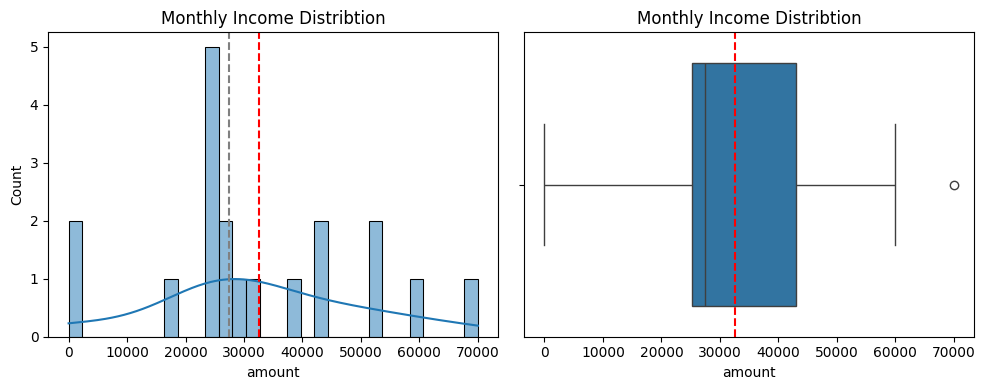

In [61]:
# Distribution Plot for Monlthy Income 
dict_data_income = {'Monthly Income Distribtion': stats_monthly_income.data}
plot_distribution(dataset=dict_data_income)

# Checking Skewness
print(f"Skewness = {scistat.skew(stats_monthly_income.data):.3f}")

Text(0.5, 1.0, 'Autocorrelation Plot of Monthly Income')

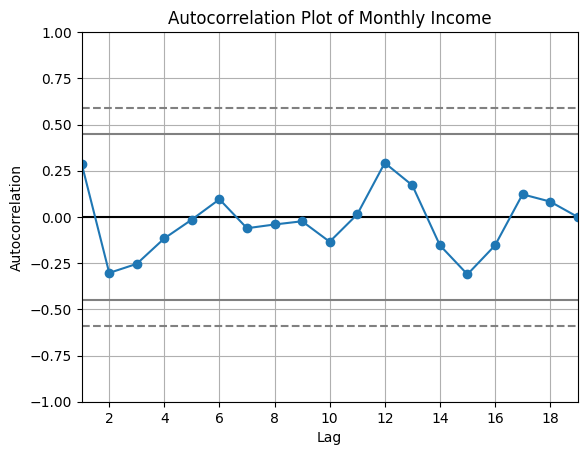

In [62]:
# Validating Independence and Random Condition via Autocorrelation Plot
pd.plotting.autocorrelation_plot(stats_monthly_income.data, marker='o')
plt.title('Autocorrelation Plot of Monthly Income')

### **Interpretation:**
- The plot tests whether the data values are correlated with their own past.
- Data points are not going beyong the border inside that spans from 0.
    - Meaning **data points are independent** from the previous data point.

✅**Independence:**
- Data are contained inside ~$\pm\; 0.49$.
- **Data points are independent** to prior data point.

✅**Randomness:**
- Data are independent in the plot.
- Randomness seems **statistically valid and justified**.

##### Hypothesis Testing:
- It is safe to assume that the **conditions of normality, independence, and randomness are met**.
- **Parametric hypothesis test would be safe to use**.
    - We'll use **1-sample t test**.

In [63]:
# 1-sample t test
confidence_lvl = 0.05

tstat, pvalue = scistat.ttest_1samp(a=stats_monthly_income.data, popmean=21_000)
print(f"p-value = {pvalue:.3f}")
print(f"Cofidence Level = {confidence_lvl}")

print('\nConclusion:')
interp_pvalue(p_value=pvalue, alpha=confidence_lvl)

p-value = 0.012
Cofidence Level = 0.05

Conclusion:
Reject Null Hypothesis. alpha < p-value is False


#### **Interpretation:**
- Reject null hypothesis.
- Data suggests that it is **likely unusual** to have $\text{Php}\: 21,000$ monthly income.
- There's **NOT enough evidence** to conclude that it is **NOT unusual** to have $\text{Php}\: 21,000$ monthly income.